In [ ]:
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
import os

# Create output directory if it doesn't exist
output_dir = 'data/raw/'
os.makedirs(output_dir, exist_ok=True)

# Example using Google Image crawler
def crawl_google_images(keyword, max_num=100):
     """
     Download images from Google using the provided keyword
     
     Args:
          keyword: Search term
          max_num: Maximum number of images to download (default: 100)
     """
     google_crawler = GoogleImageCrawler(
          storage={'root_dir': os.path.join(output_dir, 'google', keyword)})
     
     google_crawler.crawl(keyword=f'{keyword} track layout 2024', max_num=max_num)
     print(f"Downloaded up to {max_num} images for '{keyword}' from Google")

# Example using Bing Image crawler
def crawl_bing_images(keyword, max_num=100):
     """
     Download images from Bing using the provided keyword
     
     Args:
          keyword: Search term
          max_num: Maximum number of images to download (default: 100)
     """
     bing_crawler = BingImageCrawler(
          storage={'root_dir': os.path.join(output_dir, 'bing', keyword)})
     
     bing_crawler.crawl(keyword=f'{keyword} track layout 2024', max_num=max_num)
     print(f"Downloaded up to {max_num} images for '{keyword}' from Bing")

# Usage example
search_terms = [
    "Bahrain International Circuit",
    "Jeddah Corniche Circuit",
    "Albert Park Circuit",
    "Suzuka International Racing Course",
    "Shanghai International Circuit",
    "Miami International Autodrome",
    "Imola (Autodromo Enzo e Dino Ferrari)",
    "Circuit de Monaco",
    "Circuit Gilles Villeneuve",
    "Circuit de Barcelona-Catalunya",
    "Red Bull Ring",
    "Silverstone Circuit",
    "Hungaroring",
    "Circuit de Spa-Francorchamps",
    "Circuit Zandvoort",
    "Monza (Autodromo Nazionale Monza)",
    "Baku City Circuit",
    "Marina Bay Street Circuit",
    "Circuit of the Americas",
    "Autódromo Hermanos Rodríguez",
    "Interlagos (Autódromo José Carlos Pace)",
    "Las Vegas Street Circuit",
    "Lusail International Circuit",
    "Yas Marina Circuit"
]
for term in search_terms:
    crawl_google_images(term, max_num=30)
    crawl_bing_images(term, max_num=30)

In [39]:
import torch
import random
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import time
import copy

In [7]:
def setup_model(num_classes=2):
    # Load pre-trained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    # Move model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")
    
    return model, device

In [31]:
def filter_images(model, model_path='f1_track_classifier.pth', 
                            source_dir='data/raw',
                            filtered_dir='data/filtered_images'):
     
     if isinstance(model, str):
        # Load model from saved state
        # Ensure setup_model is defined earlier in the notebook
        try:
            model, _ = setup_model() 
            model.load_state_dict(torch.load(model_path))
        except NameError:
             print("Error: setup_model function not defined. Cannot load model from path.")
             return 0, 0
        except FileNotFoundError:
             print(f"Error: Model file not found at {model_path}")
             return 0, 0
     
     model.eval()
     device = next(model.parameters()).device

     val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
     
     os.makedirs(filtered_dir, exist_ok=True)

     total_images = 0
     filtered_images = 0

     for source in os.listdir(source_dir):
          source_path = os.path.join(source_dir, source)
          if not os.path.isdir(source_path):
               continue
          for track in os.listdir(source_path):
               track_path = os.path.join(source_path, track)
               if not os.path.isdir(track_path):
                    continue
               os.makedirs(os.path.join(filtered_dir, track), exist_ok=True)

               for img_name in os.listdir(track_path):
                    img_path = os.path.join(track_path, img_name)
                    total_images += 1

                    try:
                         img = Image.open(img_path).convert('RGB')
                         img_tensor = val_transforms(img).unsqueeze(0).to(device)

                         with torch.no_grad():
                              output = model(img_tensor)
                              _, predicted = torch.max(output, 1)
                         
                         if predicted.item() == 0:
                              filtered_images += 1
                              shutil.copy(img_path, os.path.join(filtered_dir, track, f'{source}_{img_name}'))
                    except Exception as e:
                         print(f"Error processing image {img_path}: {e}")
     # Report statistics
     print(f"\nProcessing complete!")
     print(f"Total images processed: {total_images}")
     print(f"Images with layout: {filtered_images}")
     # Add check for total_images before division
     if total_images > 0:
          print(f"Clean Images rate: {filtered_images/total_images*100:.1f}%")
     else:
          print("Clean Images rate: N/A (No images processed)")
    
     return None
                         

In [ ]:
filter_images('layout_classifiier.pth')

Using device: cpu


/var/folders/df/3_ym9w5d05gbbkc5t4gh1kn80000gn/T/ipykernel_68121/1792424102.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Error processing image data/raw/google/Bahrain International Circuit/.DS_Store: cannot identify image file '/Users/bszczesniak/projekty/f1-layout-recognition/data/raw/google/Bahrain International Circuit/.DS_Store'

Processing complete!
Total images processed: 1369
Images with layout: 1109
Clean Images rate: 81.0%


In [ ]:
def clean_folders():
     removed = 0
     for source in os.listdir('data/raw'):
         source_path = os.path.join('data/raw', source)
         if not os.path.isdir(source_path):
               continue
         for track in os.listdir(source_path):
              track_path = os.path.join(source_path, track)
              if not os.path.isdir(track_path):
               continue
              for img_name in os.listdir(track_path):
                   if img_name.startswith(source):
                         img_path = os.path.join(track_path, img_name)
                         os.remove(img_path)
                         removed += 1
                         print(f"Removed {img_path}")
     return removed

print(clean_folders())

In [79]:
# Insert this code into a new cell after the filtering/cleaning cells

import torch
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from pathlib import Path

# --- Configuration ---
filtered_data_dir = Path('data/filtered_images') # Use the directory with filtered images
batch_size = 32 # You can adjust this
img_size = 224 # Standard size for many pre-trained models like ResNet

# Check if the filtered data directory exists
if not filtered_data_dir.is_dir():
    print(f"Error: Filtered data directory not found at '{filtered_data_dir}'")
    print("Please ensure the image filtering step has been run successfully.")
    # Optionally, raise an error or stop execution
    # raise FileNotFoundError(f"Directory not found: {filtered_data_dir}")
else:
    print(f"Using data from: {filtered_data_dir}")

    # --- Data Transforms ---
    # Define transforms for training (with augmentation) and validation/testing
    # Using standard ImageNet normalization stats as we'll likely use a pre-trained model
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(15), # Added slight rotation augmentation
            # transforms.RandomAffine(
            #     degrees=0,
            #     translate=(0.1, 0.1),
            #     scale=(0.9, 1.1),
            #     shear=10                                         # imituje krzywienie przy rysowaniu
            # ),
            # transforms.RandomErasing(p=0.3, scale=(0.01, 0.05)), # losowe przerwy w linii
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # rozmycie kreski
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: x + 0.03 * torch.randn_like(x)), # szum jak z myszki/ekranu
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)), # Resize slightly larger than crop size
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # --- Dataset ---
    # Load the full dataset from the filtered directory using ImageFolder
    # ImageFolder automatically assigns labels based on subfolder names
    try:
        full_dataset = datasets.ImageFolder(filtered_data_dir)
        class_names = full_dataset.classes
        num_classes = len(class_names)
        class_to_idx = full_dataset.class_to_idx
        idx_to_class = {v: k for k, v in class_to_idx.items()}

        print(f"Found {len(full_dataset)} images in {num_classes} classes.")
        print("Classes found:", class_names)
        # print("Class to index mapping:", class_to_idx) # Uncomment to see mapping

        if len(full_dataset) == 0:
             print("Warning: The dataset is empty. Check the filtering process and the contents of", filtered_data_dir)

        # --- Split Dataset ---
        # Define split sizes (e.g., 80% train, 20% validation)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size

        # Perform the random split
        # Ensure reproducibility if needed by setting torch.manual_seed() before this
        # torch.manual_seed(42)
        train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])
        print(f"Splitting data: {train_size} training images, {val_size} validation images.")

        # Create Subset datasets for train and validation
        train_subset = Subset(full_dataset, train_indices)
        val_subset = Subset(full_dataset, val_indices)

        # --- Apply Transforms to Subsets ---
        # We need to apply the correct transforms to each subset.
        # A common way is to create a small wrapper class or modify the __getitem__
        class TransformedSubset(torch.utils.data.Dataset):
            def __init__(self, subset, transform=None):
                self.subset = subset
                self.transform = transform

            def __getitem__(self, index):
                # Get the original image and label from the underlying ImageFolder dataset
                x, y = self.subset.dataset.samples[self.subset.indices[index]]
                # Load the image
                img = datasets.folder.default_loader(x)
                # Apply the transform
                if self.transform:
                    img = self.transform(img)
                return img, y # Return transformed image and original label index

            def __len__(self):
                return len(self.subset)

        train_transformed_dataset = TransformedSubset(train_subset, transform=data_transforms['train'])
        val_transformed_dataset = TransformedSubset(val_subset, transform=data_transforms['val'])

        # --- DataLoaders ---
        dataloaders = {
            'train': DataLoader(train_transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True),
            'val': DataLoader(val_transformed_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
        }

        dataset_sizes = {'train': len(train_transformed_dataset), 'val': len(val_transformed_dataset)}

        print("DataLoaders created successfully.")
        # You can now access dataloaders['train'] and dataloaders['val']

        # Optional: Verify by loading one batch
        try:
            inputs, classes = next(iter(dataloaders['train']))
            print("Sample batch loaded successfully.")
            print("Input shape:", inputs.shape) # Should be [batch_size, 3, img_size, img_size]
            print("Classes shape:", classes.shape) # Should be [batch_size]
        except Exception as e:
             print(f"Error loading sample batch: {e}")


    except FileNotFoundError:
        print(f"Error: Could not find dataset at '{filtered_data_dir}'. Make sure the path is correct and contains subdirectories for each class.")
    except Exception as e:
        print(f"An error occurred during dataset/dataloader creation: {e}")


Using data from: data/filtered_images
Found 1109 images in 24 classes.
Classes found: ['Albert Park Circuit', 'Autódromo Hermanos Rodríguez', 'Bahrain International Circuit', 'Baku City Circuit', 'Circuit Gilles Villeneuve', 'Circuit Zandvoort', 'Circuit de Barcelona-Catalunya', 'Circuit de Monaco', 'Circuit de Spa-Francorchamps', 'Circuit of the Americas', 'Hungaroring', 'Imola (Autodromo Enzo e Dino Ferrari)', 'Interlagos (Autódromo José Carlos Pace)', 'Jeddah Corniche Circuit', 'Las Vegas Street Circuit', 'Lusail International Circuit', 'Marina Bay Street Circuit', 'Miami International Autodrome', 'Monza (Autodromo Nazionale Monza)', 'Red Bull Ring', 'Shanghai International Circuit', 'Silverstone Circuit', 'Suzuka International Racing Course', 'Yas Marina Circuit']
Splitting data: 887 training images, 222 validation images.
DataLoaders created successfully.
Sample batch loaded successfully.
Input shape: torch.Size([32, 3, 224, 224])
Classes shape: torch.Size([32])


In [38]:
learning_rate = 0.001
num_epochs = 15 # Start with 15-25 epochs, adjust based on results
model_save_path = 'f1_track_layout_resnet18_v1.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
        param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using device: mps


Starting training...
Epoch 1/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.6788 Acc: 0.5039
val Loss: 1.1791 Acc: 0.7252
Saved new best model to f1_track_layout_resnet18_v1_unfiltered_best.pth with accuracy: 0.7252

Epoch 2/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.7068 Acc: 0.4915
val Loss: 1.2290 Acc: 0.6937

Epoch 3/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.6512 Acc: 0.5141
val Loss: 1.2537 Acc: 0.6847

Epoch 4/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.6311 Acc: 0.5186
val Loss: 1.2028 Acc: 0.7207

Epoch 5/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.5620 Acc: 0.5276
val Loss: 1.2531 Acc: 0.6802

Epoch 6/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.5005 Acc: 0.5468
val Loss: 1.3080 Acc: 0.6216

Epoch 7/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.4649 Acc: 0.5536
val Loss: 1.3045 Acc: 0.6396

Epoch 8/20
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.4477 Acc: 0.5581
val Loss: 1.3115 Acc: 0.666

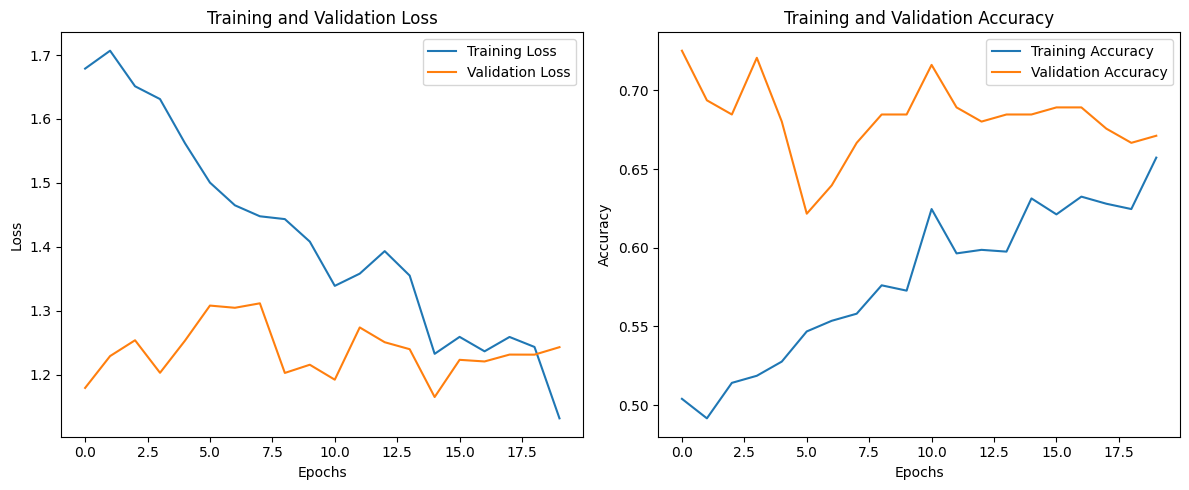

Training finished and history plotted.


In [80]:
# Insert this code into a new cell after the Model/Loss/Optimizer cell

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    # Ensure dataloaders and dataset_sizes are accessible
    if 'dataloaders' not in globals() or 'dataset_sizes' not in globals():
        raise NameError("Variables 'dataloaders' or 'dataset_sizes' not defined. Please run the cell that creates them.")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_count = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_count += 1
                # Optional: Print progress within epoch
                if batch_count % 10 == 0:
                   print(f"  Batch {batch_count}/{len(dataloaders[phase])}")


            # Optional LR scheduler step (uncomment if using scheduler)
            # if phase == 'train' and scheduler:
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item()) # Use .item() to get Python number
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item()) # Use .item() to get Python number

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model weights immediately
                best_model_path = model_save_path.replace('.pth', '_unfiltered_best.pth')
                torch.save(model.state_dict(), best_model_path)
                print(f"Saved new best model to {best_model_path} with accuracy: {best_acc:.4f}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights back into model
    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accs, val_accs)

# --- Start Training ---
print("Starting training...")
# Ensure model, criterion, optimizer are defined from the previous cell
trained_model, history = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# --- Save the final (best) trained model ---
# The best model was already saved during training, but you can save the final state too if desired
# final_model_path = model_save_path.replace('.pth', '_final.pth')
# torch.save(trained_model.state_dict(), final_model_path)
# print(f"Final model state saved to {final_model_path}") # Usually the '_best.pth' is preferred

# --- Plot Training History ---
# Extract history
train_losses, val_losses, train_accs, val_accs = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accs, label='Training Accuracy')
plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished and history plotted.")

Starting training...
Epoch 0/9
----------


/opt/anaconda3/envs/emotion-env/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Batch 10/28
  Batch 20/28
train Loss: 2.5784 Acc: 0.2153
val Loss: 2.6470 Acc: 0.2162
Saved new best model to f1_track_layout_resnet18_v1_best.pth with accuracy: 0.2162

Epoch 1/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.4272 Acc: 0.2717
val Loss: 2.6632 Acc: 0.1892

Epoch 2/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.3627 Acc: 0.3010
val Loss: 2.6122 Acc: 0.1982

Epoch 3/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.2937 Acc: 0.3315
val Loss: 2.5883 Acc: 0.2432
Saved new best model to f1_track_layout_resnet18_v1_best.pth with accuracy: 0.2432

Epoch 4/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.2975 Acc: 0.3145
val Loss: 2.6693 Acc: 0.2072

Epoch 5/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.2955 Acc: 0.3191
val Loss: 2.6511 Acc: 0.2297

Epoch 6/9
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.2147 Acc: 0.3517
val Loss: 2.5752 Acc: 0.2477
Saved new best model to f1_track_layout_resnet18_v1_best.pth with accuracy: 0.2477

Ep

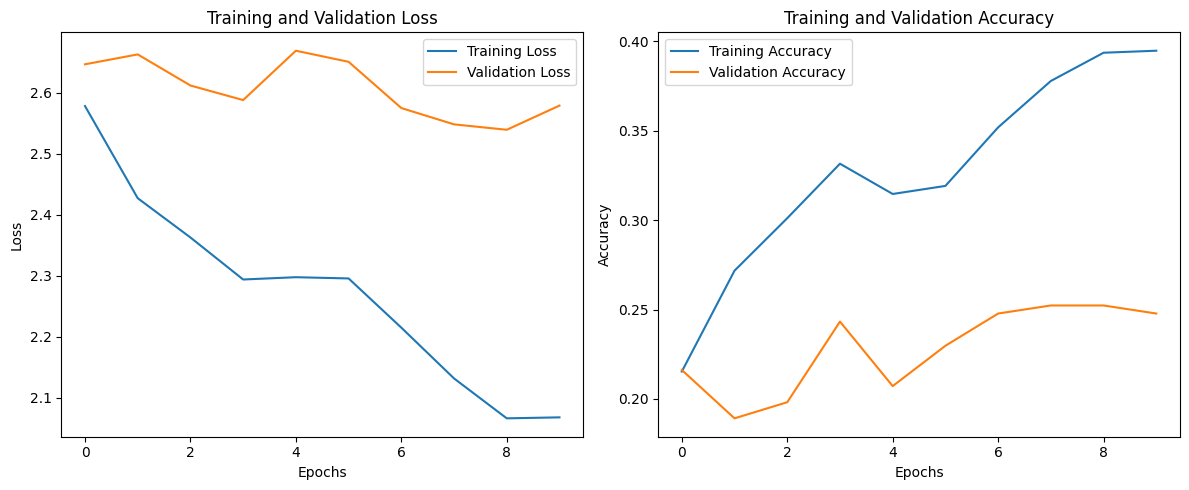

Training finished and history plotted.


In [ ]:
print("Starting training...")
# Ensure model, criterion, optimizer are defined from the previous cell
trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)

# --- Save the final (best) trained model ---
# The best model was already saved during training, but you can save the final state too if desired
# final_model_path = model_save_path.replace('.pth', '_final.pth')
# torch.save(trained_model.state_dict(), final_model_path)
# print(f"Final model state saved to {final_model_path}") # Usually the '_best.pth' is preferred

# --- Plot Training History ---
# Extract history
train_losses, val_losses, train_accs, val_accs = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(10), train_losses, label='Training Loss')  # Updated to match num_epochs=6
plt.plot(range(10), val_losses, label='Validation Loss')  # Updated to match num_epochs=6
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(10), train_accs, label='Training Accuracy')  # Updated to match num_epochs=6
plt.plot(range(10), val_accs, label='Validation Accuracy')  # Updated to match num_epochs=6
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished and history plotted.")

In [81]:
os.makedirs("train_preview", exist_ok=True)
from torchvision.utils import save_image
images, labels = next(iter(dataloaders['train']))
# Zapisz pierwsze 8 obrazów
for i in range(8, 16):
    save_image(images[i], f"train_preview/img_{i}_label_{labels[i].item()}.png")
os.makedirs("val_preview", exist_ok=True)
images, labels = next(iter(dataloaders['val']))
# Zapisz pierwsze 8 obrazów
for i in range(8, 16):
    save_image(images[i], f"val_preview/img_{i}_label_{labels[i].item()}.png")

Starting training...
Epoch 0/19
----------


/opt/anaconda3/envs/emotion-env/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Batch 10/28
  Batch 20/28
train Loss: 2.2018 Acc: 0.3551
val Loss: 2.2470 Acc: 0.3423
Saved new best model to f1_track_layout_resnet18_v1_best.pth with accuracy: 0.3423

Epoch 1/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.1509 Acc: 0.3777
val Loss: 2.3536 Acc: 0.2928

Epoch 2/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 2.0544 Acc: 0.3867
val Loss: 2.2757 Acc: 0.3378

Epoch 3/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.9590 Acc: 0.4318
val Loss: 2.4340 Acc: 0.2883

Epoch 4/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.9567 Acc: 0.4273
val Loss: 2.1385 Acc: 0.3874
Saved new best model to f1_track_layout_resnet18_v1_best.pth with accuracy: 0.3874

Epoch 5/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.9250 Acc: 0.4352
val Loss: 2.2349 Acc: 0.3423

Epoch 6/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.8534 Acc: 0.4679
val Loss: 2.3127 Acc: 0.3108

Epoch 7/19
----------
  Batch 10/28
  Batch 20/28
train Loss: 1.8670 Acc: 0.447

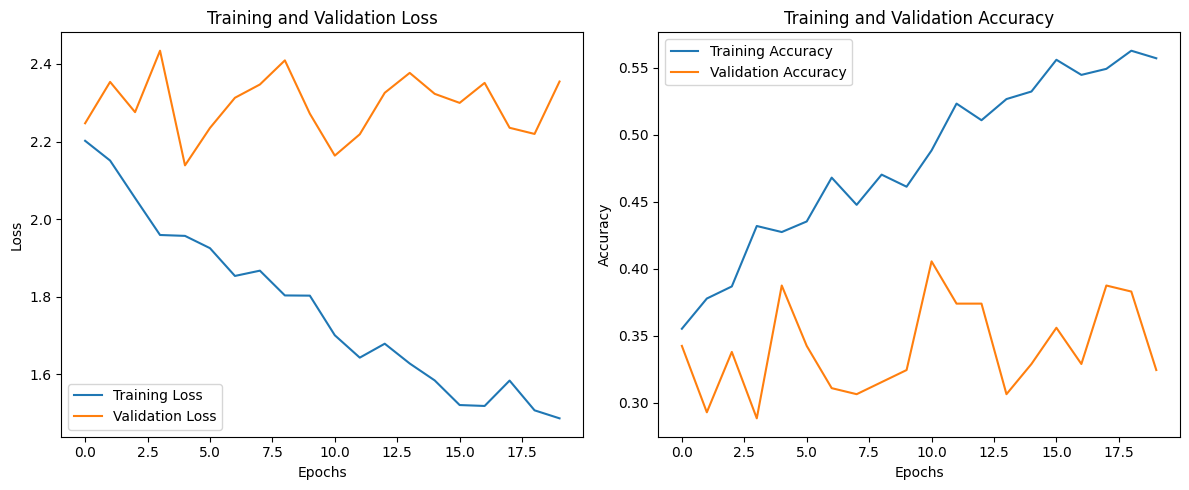

Training finished and history plotted.


In [67]:
print("Starting training...")
num_epochs = 20
# Ensure model, criterion, optimizer are defined from the previous cell
trained_model, history = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# --- Save the final (best) trained model ---
# The best model was already saved during training, but you can save the final state too if desired
# final_model_path = model_save_path.replace('.pth', '_final.pth')
# torch.save(trained_model.state_dict(), final_model_path)
# print(f"Final model state saved to {final_model_path}") # Usually the '_best.pth' is preferred

# --- Plot Training History ---
# Extract history
train_losses, val_losses, train_accs, val_accs = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')  # Updated to match num_epochs=6
plt.plot(range(num_epochs), val_losses, label='Validation Loss')  # Updated to match num_epochs=6
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accs, label='Training Accuracy')  # Updated to match num_epochs=6
plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')  # Updated to match num_epochs=6
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished and history plotted.")